In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [27]:
# Seed for reproducibility
np.random.seed(42)

# Date range
date_range = pd.date_range(start='2019-01-01', end='2023-12-31', freq='M')

# Generate sample sales data
def generate_sales_data(base, seasonality, trend, noise_level=0.1):
    n = len(date_range)
    trend_component = trend * np.arange(n)
    seasonality_component = seasonality * np.sin(np.linspace(0, 2 * np.pi * 5, n))  # Seasonality over 5 years
    noise = noise_level * np.random.randn(n) * base
    sales = base + trend_component + seasonality_component + noise
    return sales

# Parameters
base_sales = 500  # Base sales value
trend = 5  # Trend component
seasonality = 100  # Seasonality component

# Generate data
sales_data = generate_sales_data(base_sales, seasonality, trend)

# Create DataFrame with Date as index
sales_df = pd.DataFrame({'Sales': sales_data}, index=date_range)

# Ensure no negative sales
sales_df['Sales'] = sales_df['Sales'].apply(lambda x: max(x, 0))

# Display first few rows of the DataFrame
print(sales_df.head())

                 Sales
2019-01-31  524.835708
2019-02-28  548.853365
2019-03-31  629.860735
2019-04-30  691.116054
2019-05-31  593.065774


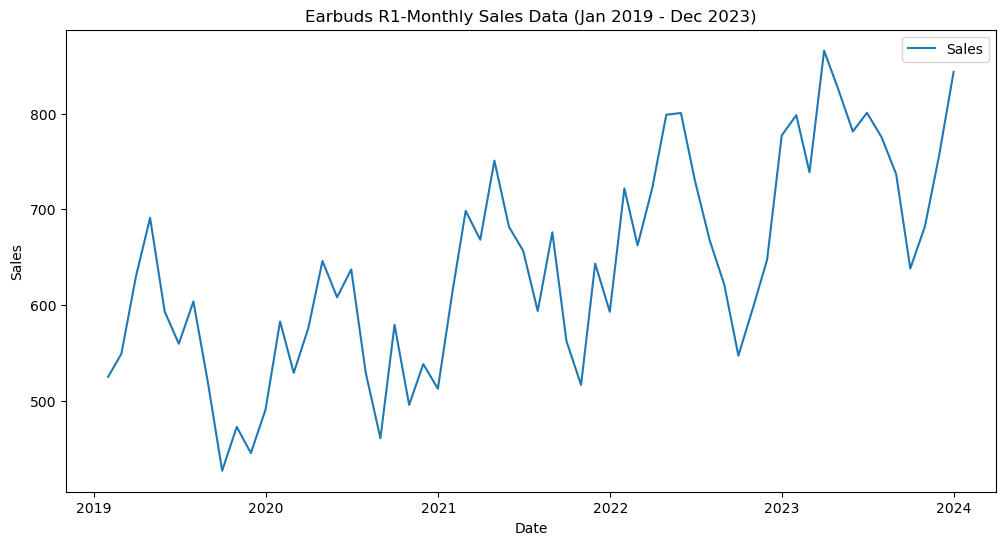

In [28]:
import matplotlib.pyplot as plt

# Plot the sales data
plt.figure(figsize=(12, 6))
plt.plot(sales_df['Sales'], label='Sales')
plt.title('Earbuds R1-Monthly Sales Data (Jan 2019 - Dec 2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [29]:
from statsmodels.tsa.stattools import adfuller

In [30]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [31]:
adf_test(sales_df)

ADF Statistics: 0.8731600976183209
p- value: 0.9927298687740623
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [32]:
sales_df_diff= sales_df.diff().dropna()

Text(0.5, 1.0, 'Earbuds R1- First Difference')

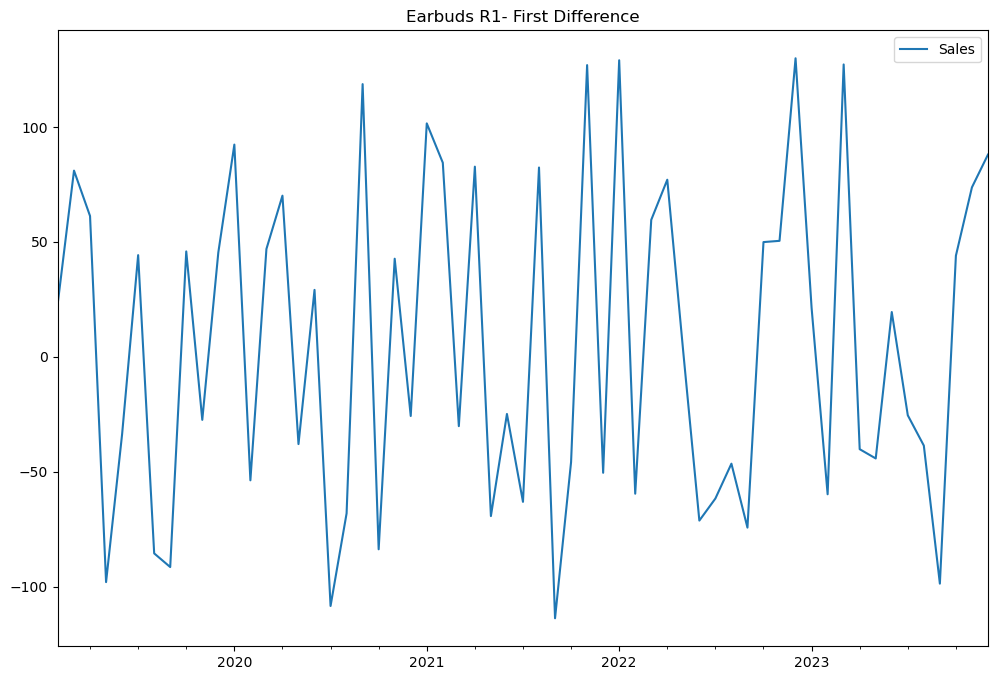

In [33]:
sales_df_diff.plot(figsize=(12,8))
plt.title('Earbuds R1- First Difference')

In [34]:
adf_test(sales_df_diff)

ADF Statistics: -6.952239745785355
p- value: 9.626449877933814e-10
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [35]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

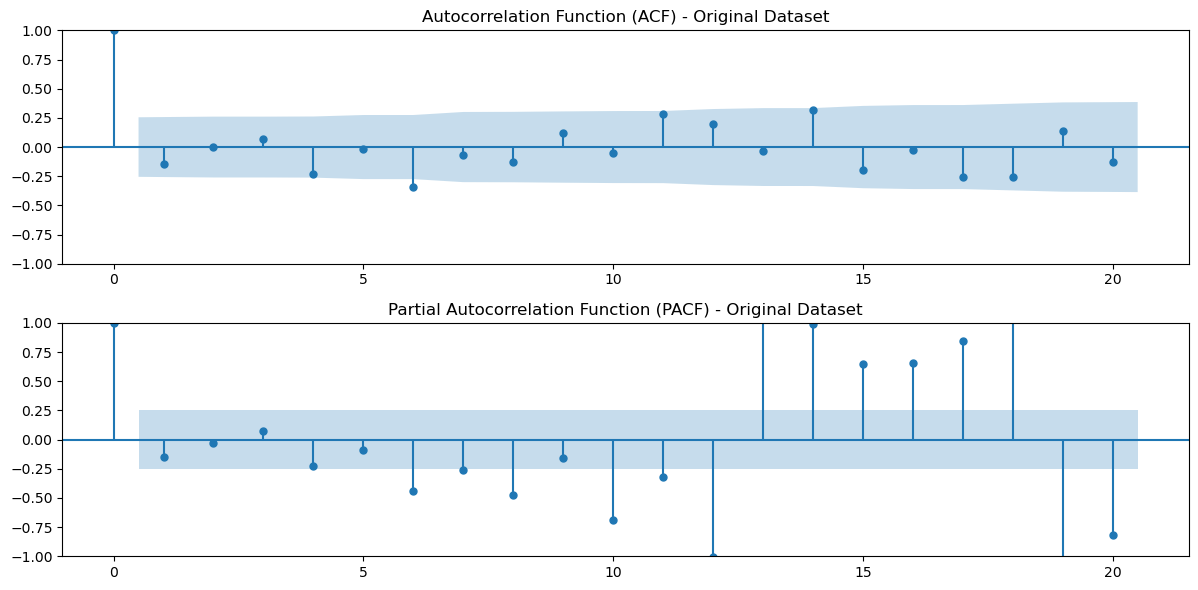

In [36]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_df_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Dataset')

plt.subplot(212)
plot_pacf(sales_df_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Dataset')

plt.tight_layout()
plt.show()

In [37]:
train= sales_df[:57]
test=sales_df[57:]

In [38]:
print(len(train),len(test))

57 3


In [39]:
order=[]
for p in range(11):
    # Loop over MA order
    for q in range(3):
        # Fit model        
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_df)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [40]:
# Sort by AIC
print(order_df.sort_values('aic'))

     p  q         aic         bic         mae           mse        rmse
30  10  0  626.612433  648.891302   71.804668   6448.608514   80.303229
31  10  1  626.704888  651.009108   64.281489   5735.264002   75.731526
32  10  2  626.739338  653.068910   66.018993   6206.474615   78.781182
26   8  2  628.169023  650.447891   71.772587   7865.446116   88.687350
24   8  0  629.091429  647.319594   70.648173   7664.062523   87.544632
20   6  2  629.619016  647.847181   79.942075  10621.791713  103.062077
19   6  1  629.892841  646.095654   76.630695   9211.687994   95.977539
29   9  2  630.166949  654.471169   72.140464   7895.832958   88.858500
23   7  2  630.230753  650.484270   73.494923   9250.513633   96.179591
25   8  1  630.575028  650.828544   68.648625   7533.996291   86.798596
27   9  0  631.068359  651.321875   70.460072   7597.582222   87.164111
22   7  1  631.610650  649.838815   76.028079   8782.213742   93.713466
28   9  1  632.447258  654.726126   69.701428   7740.039552   87

In [41]:
m_arima= ARIMA(train, order=(10,1,0))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   57
Model:                ARIMA(10, 1, 0)   Log Likelihood                -302.306
Date:                Mon, 27 May 2024   AIC                            626.612
Time:                        14:46:11   BIC                            648.891
Sample:                    01-31-2019   HQIC                           635.250
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3981      0.146     -2.733      0.006      -0.684      -0.113
ar.L2         -0.4278      0.182     -2.350      0.019      -0.785      -0.071
ar.L3         -0.1388      0.163     -0.853      0.3

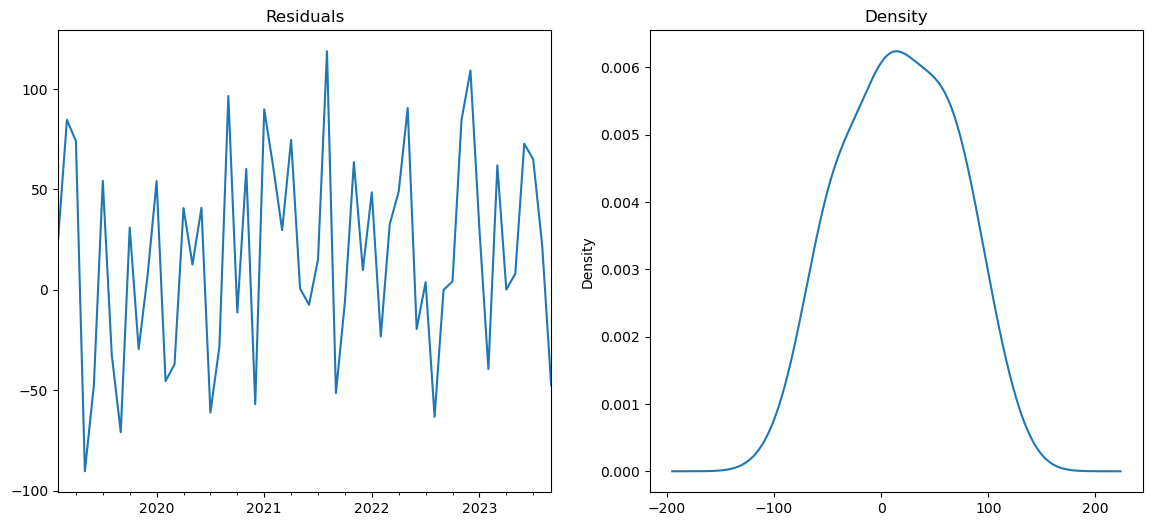

In [42]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

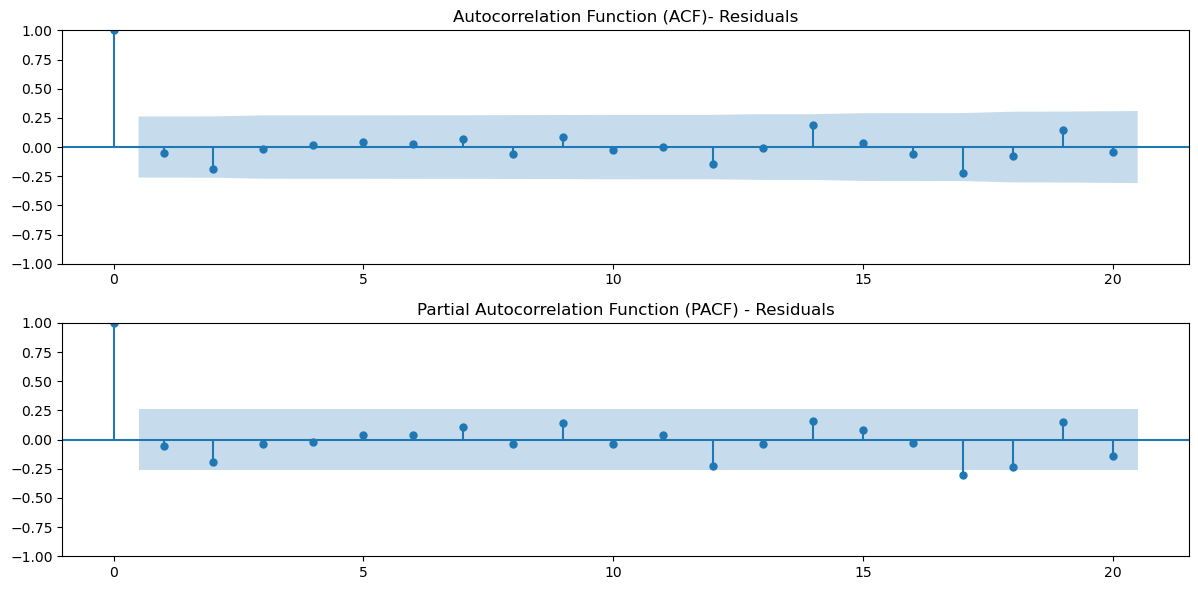

In [43]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

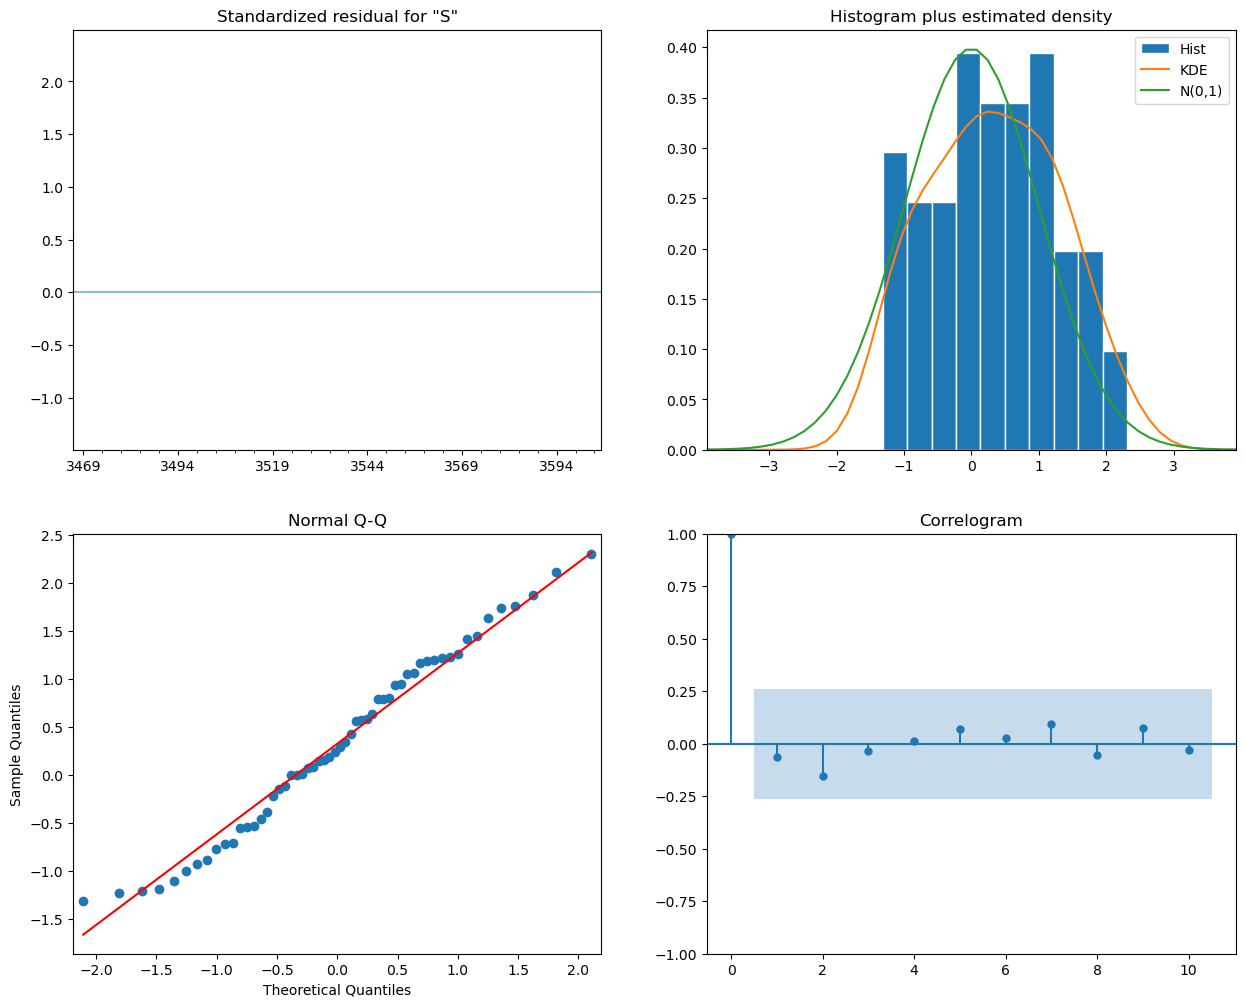

In [44]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [45]:
pred=model_arima.predict(start=len(train), end=(len(sales_df)-1), dynamic = True)
sales_df['Forecast_ARIMA']=[None]*len(train) + list(pred)

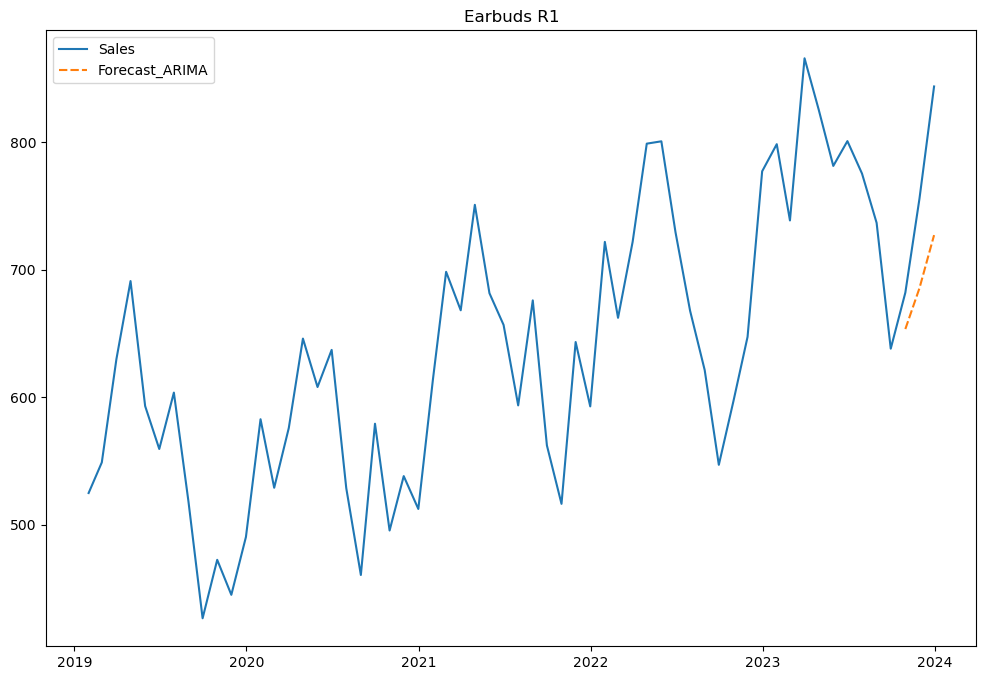

In [46]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_df[['Sales','Forecast_ARIMA']])
plt.title('Earbuds R1')
plt.show()

In [47]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 71.80466808064948
MAPE - ARIMA: 0.0910055696361966
MSE - ARIMA: 6448.608514331706
RMSE - ARIMA: 80.3032285423924


# FORECASTING

In [48]:
f_arima= ARIMA(sales_df['Sales'], order=(10,1,0))
model_f_arima=f_arima.fit()

In [51]:
forecast_=model_f_arima.predict(start=len(sales_df), end=(len(sales_df)+2), dynamic = True)

In [52]:
forecast_

2024-01-31    809.585749
2024-02-29    817.431393
2024-03-31    871.058181
Freq: M, Name: predicted_mean, dtype: float64

In [53]:
arima_forecast_model=model_f_arima.get_forecast(steps=3)

mean_forecast= arima_forecast_model.predicted_mean
dates = mean_forecast.index

confidence_intervals= arima_forecast_model.conf_int()

In [54]:
print(mean_forecast,confidence_intervals)

2024-01-31    809.585749
2024-02-29    817.431393
2024-03-31    871.058181
Freq: M, Name: predicted_mean, dtype: float64             lower Sales  upper Sales
2024-01-31   708.666932   910.504565
2024-02-29   699.009187   935.853599
2024-03-31   748.600045   993.516317


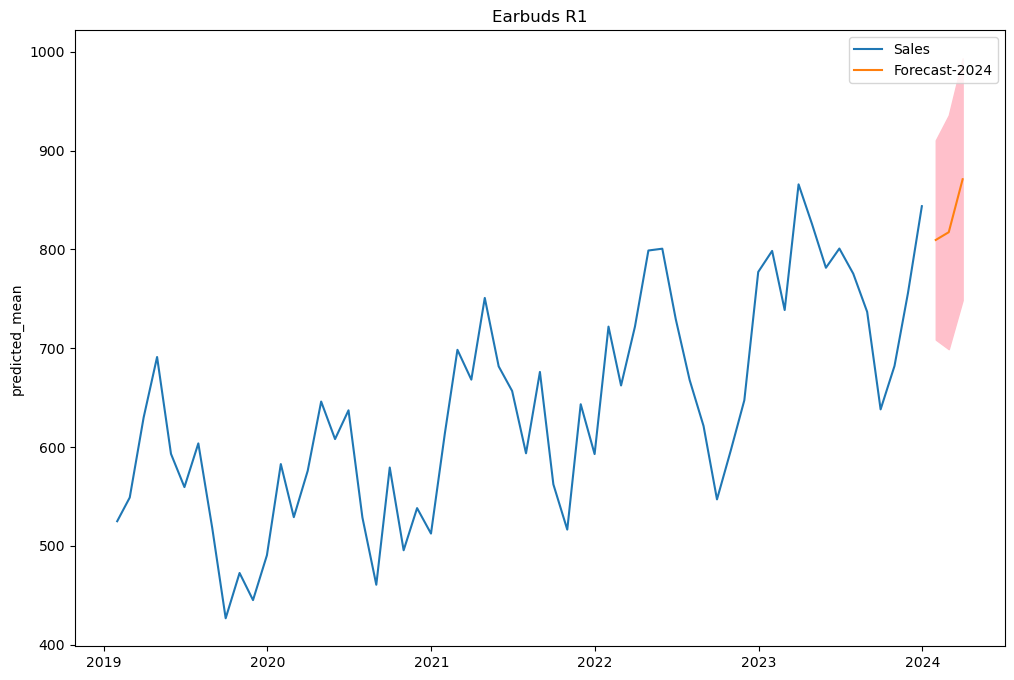

In [55]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_df[['Sales']])
sns.lineplot(mean_forecast,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals['lower Sales'],confidence_intervals['upper Sales'],color='pink')
plt.title('Earbuds R1')
plt.show()

# SARIMA

In [56]:
import statsmodels.api as sm

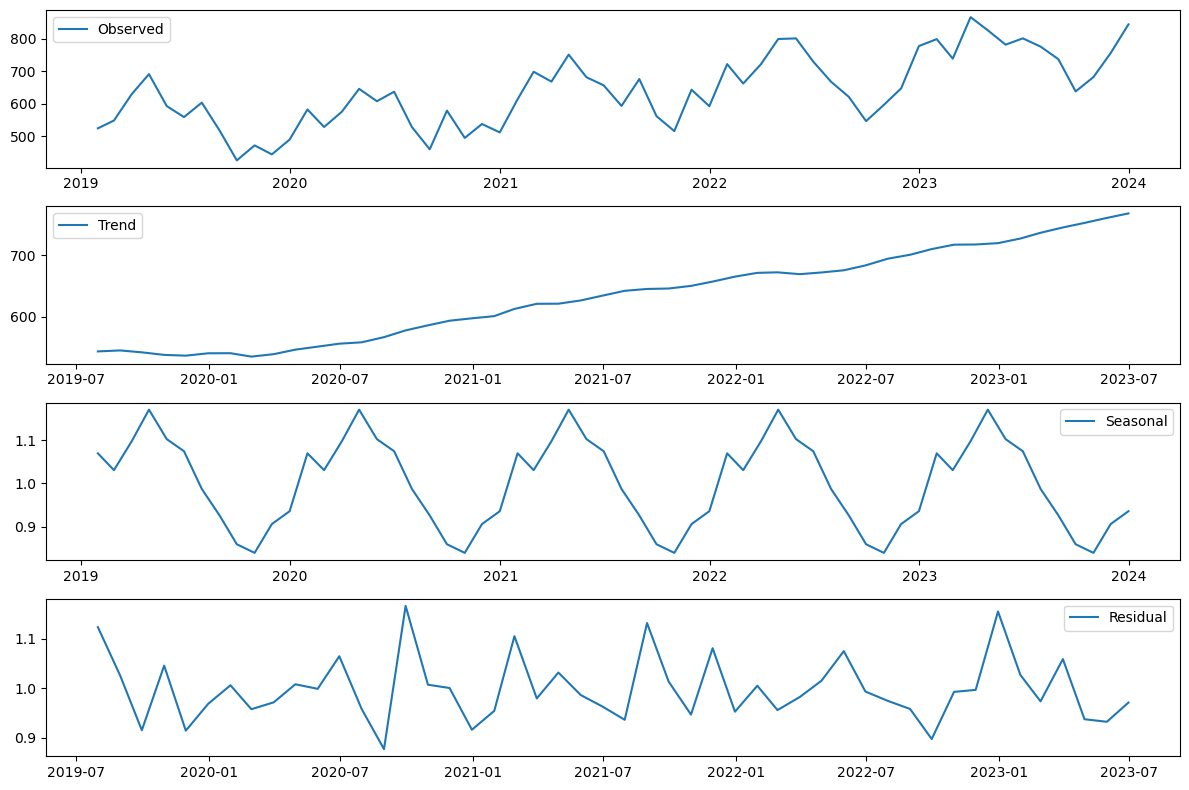

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_df['Sales'], model='multiplicative', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

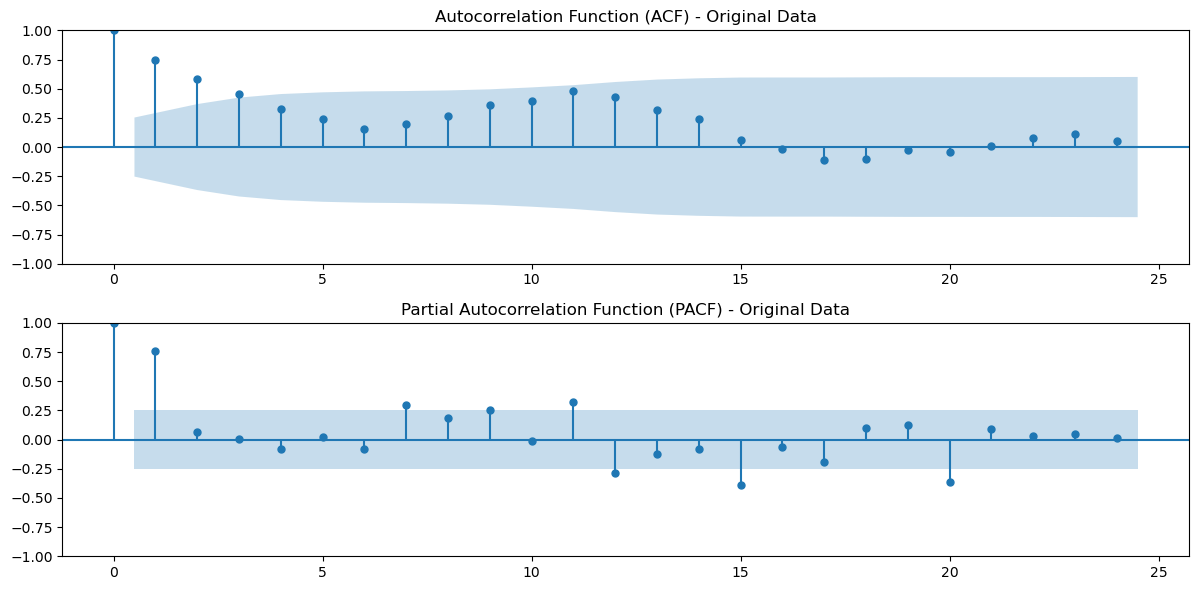

In [59]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_df['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_df['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [94]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(4):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(10, 1, 0), seasonal_order=(P, 0, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=57, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [125]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q         aic         bic         mae           mse
16  4  0  626.196719  656.576994  104.179959  13975.636541
0   0  0  626.612433  648.891302   71.804668   6448.608514
6   1  2  626.988885  655.343809   77.809265   9225.993831
9   2  1  627.550744  655.905667   66.761118   6953.598538
20  5  0  628.040700  660.446327  108.914231  15443.210337
5   1  1  628.369664  654.699236   51.126845   3279.700140
4   1  0  628.504414  652.808635   80.264141   8319.594299
8   2  0  628.537501  654.867073   49.315384   3014.474654
1   0  1  628.547243  652.851463   77.133691   7596.286079
17  4  1  628.855850  661.261477   85.617812  11830.924016
10  2  2  628.906324  659.286600   86.394240  11550.533213
7   1  3  629.022380  659.402656   81.755165   9817.487671
2   0  2  629.219125  655.548697   63.595635   5195.578930
13  3  1  629.402237  659.782512   72.935995   8463.428828
21  5  1  629.522075  663.953053  110.937575  16412.801625
12  3  0  629.564128  657.919052   49.449551   4552.6472

In [126]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(10, 1, 0),seasonal_order=(4,0,0,12))
sarima_model=sarima.fit()

In [127]:
print(sarima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   57
Model:             SARIMAX(10, 1, 0)x(4, 0, 0, 12)   Log Likelihood                -298.098
Date:                             Mon, 27 May 2024   AIC                            626.197
Time:                                     16:19:31   BIC                            656.577
Sample:                                 01-31-2019   HQIC                           637.975
                                      - 09-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4659      0.208     -2.241      0.025      -0.873      -0.058
ar.L2         -0.4838      

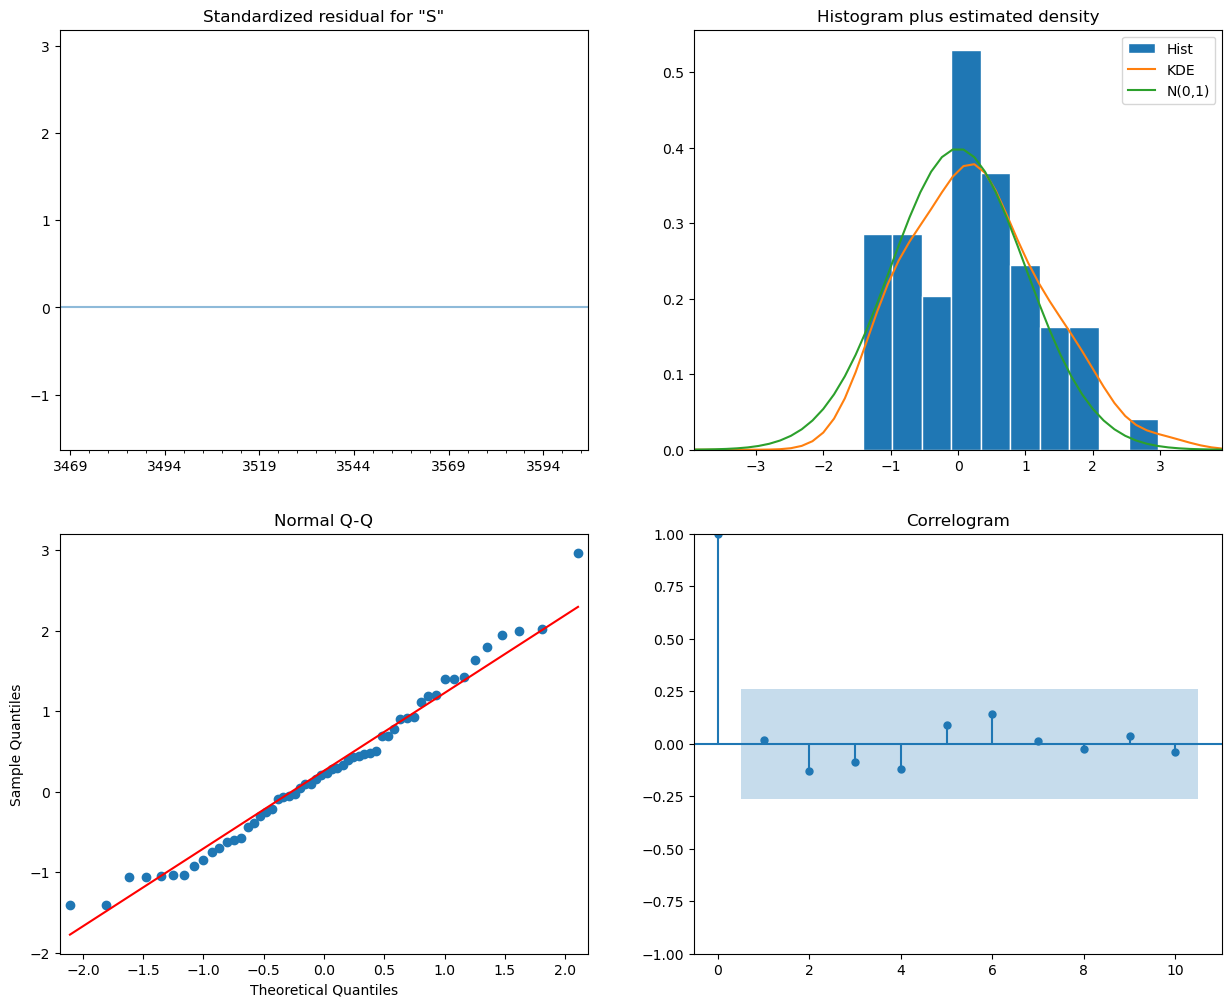

In [128]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [129]:
forecast_test_sarima=sarima_model.predict(start=57,end=59,dynamic=True)

In [130]:
sales_df['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)

Text(0.5, 1.0, 'Earbuds R1')

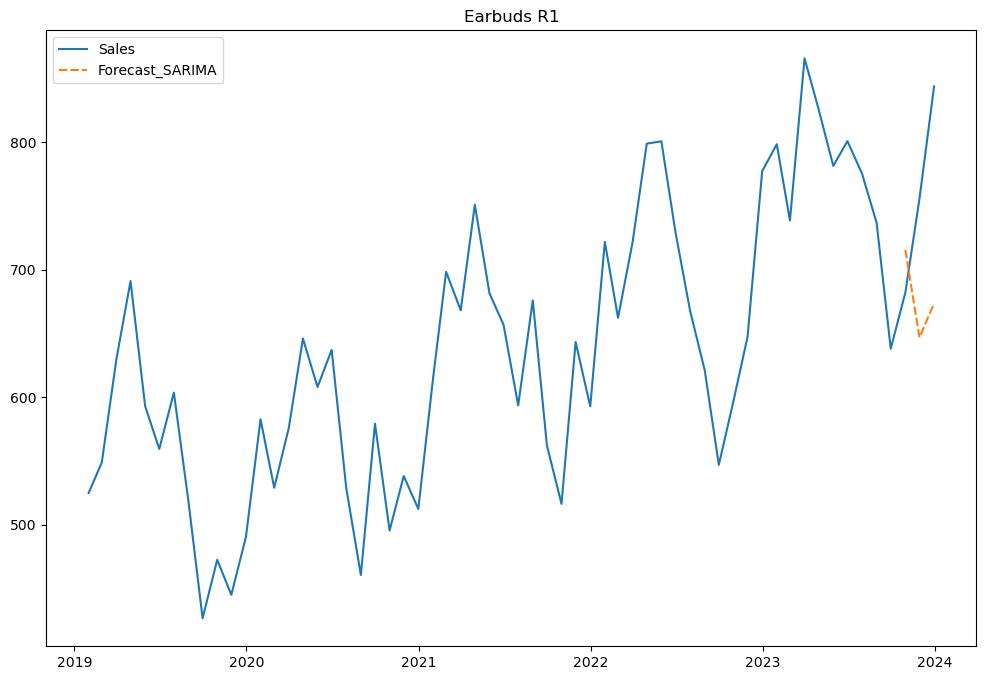

In [131]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_df[['Sales','Forecast_SARIMA']])
plt.title('Earbuds R1')

In [132]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 104.18
MAPE - SARIMA: 0.132
MSE - SARIMA: 13975.637
RMSE - SARIMA: 118.219


# FORECASTING

In [133]:
sarima_forecast=sm.tsa.statespace.SARIMAX(sales_df['Sales'],order=(10,1,0),seasonal_order=(4,0,0,12))
sarima_model_f=sarima_forecast.fit()

In [134]:
forecast_sarima=sarima_model_f.predict(start=60,end=62,dynamic=True)

In [135]:
forecast_sarima

2024-01-31    798.398716
2024-02-29    754.837681
2024-03-31    779.108666
Freq: M, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Earbuds R1')

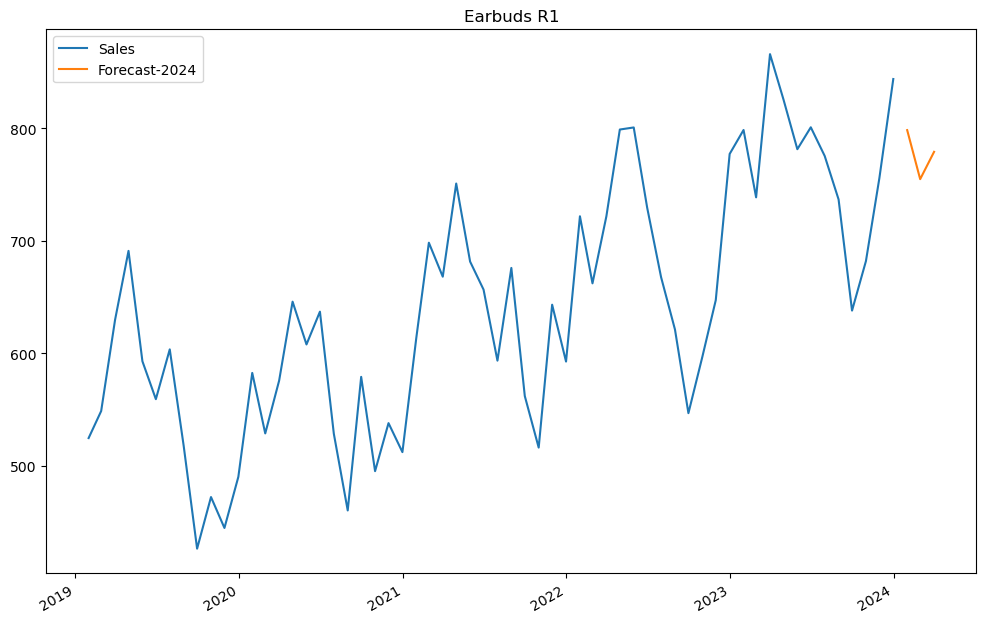

In [136]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_df[['Sales']])
forecast_sarima.plot(legend=True, label='Forecast-2024')
plt.title('Earbuds R1')

In [137]:
sarima_forecast_model=sarima_model_f.get_forecast(steps=3)

mean_forecast_sarima= sarima_forecast_model.predicted_mean
dates = mean_forecast_sarima.index

confidence_intervals_sarima= sarima_forecast_model.conf_int()

In [138]:
print(mean_forecast_sarima,confidence_intervals_sarima)

2024-01-31    798.398716
2024-02-29    754.837681
2024-03-31    779.108666
Freq: M, Name: predicted_mean, dtype: float64             lower Sales  upper Sales
2024-01-31   755.653881   841.143551
2024-02-29   707.803613   801.871748
2024-03-31   731.715468   826.501865


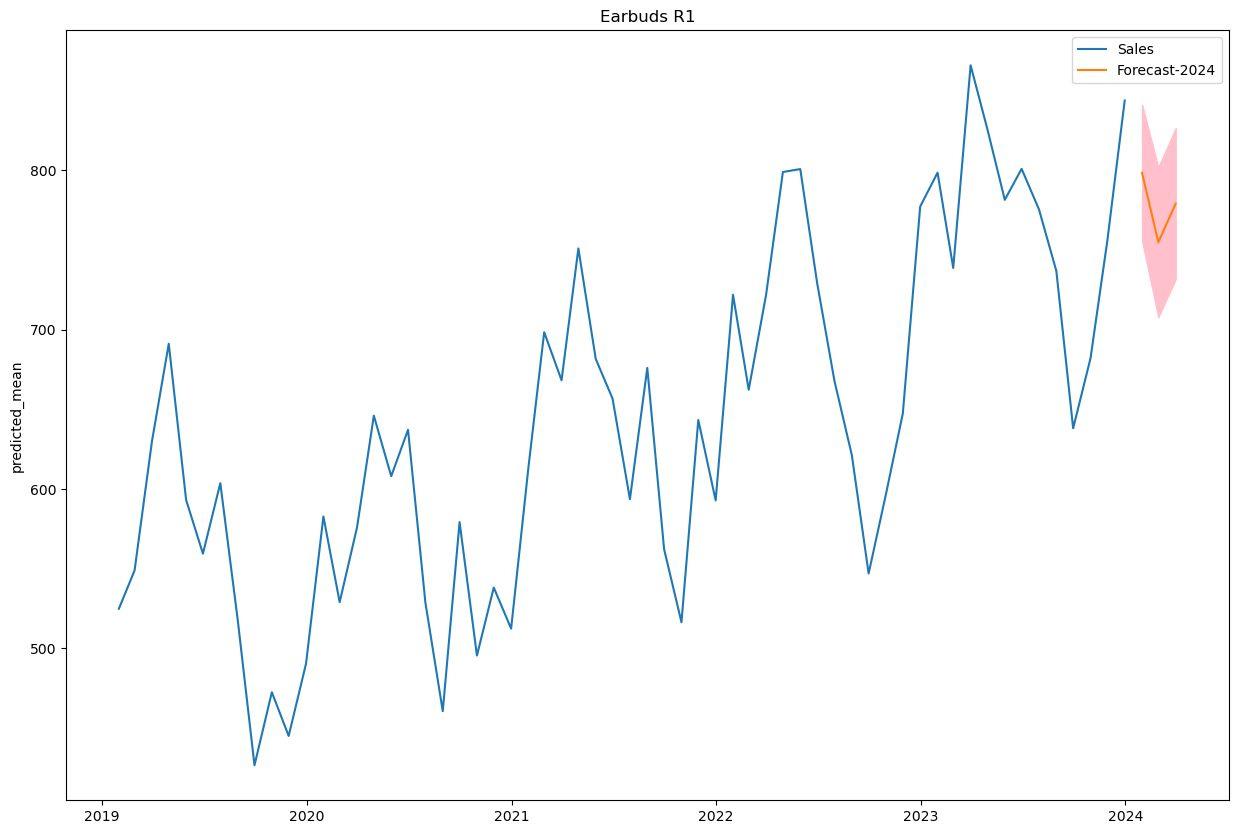

In [139]:
plt.figure(figsize=(15, 10))
sns.lineplot(sales_df[['Sales']])
sns.lineplot(mean_forecast_sarima,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals_sarima['lower Sales'],confidence_intervals_sarima['upper Sales'],color='pink')
plt.title('Earbuds R1')
plt.show()

# AUTO-ARIMA

In [70]:
import pmdarima as pm

In [72]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=10,max_q=2,
                          start_P=0, start_Q=0, max_P=5 ,max_Q=4 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=640.698, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=641.281, Time=0.15 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=643.036, Time=0.37 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=643.506, Time=0.92 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=inf, Time=11.94 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=641.071, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=inf, Time=2.86 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=inf, Time=13.90 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=642.658, Time=0.27 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=inf, Time=3.36 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=642.702, Time=0.95 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : A

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [73]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   57
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 12)   Log Likelihood                -310.040
Date:                             Mon, 27 May 2024   AIC                            634.080
Time:                                     15:17:21   BIC                            648.257
Sample:                                 01-31-2019   HQIC                           639.577
                                      - 09-30-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.8165     11.110      0.344      0.731     -17.959      25.592
ar.L1         -1.2178      0.148     -8.230      0.000      -1.508      -0.928
ar.L2         -0.4818      0.150     -3.218      0.001      -0.775      -0.188
ma.L1          0.9513      0.070     13.599      0.000       0.814       1.088
ar.S.L12       0.2836      0.119      2.384      0.017       0.050       0.517
ar.S.L24       0.3247      0.164      1.984      0.047       0.004       0.645
sigma2      3399.9224    865.808      3.927      0.000    1702.969    5096.876
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 1.04
Prob(Q):                              0.69   Prob(JB):                         0.60
Heteroskedasticity (H):               1.24   Skew:                             0.11
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

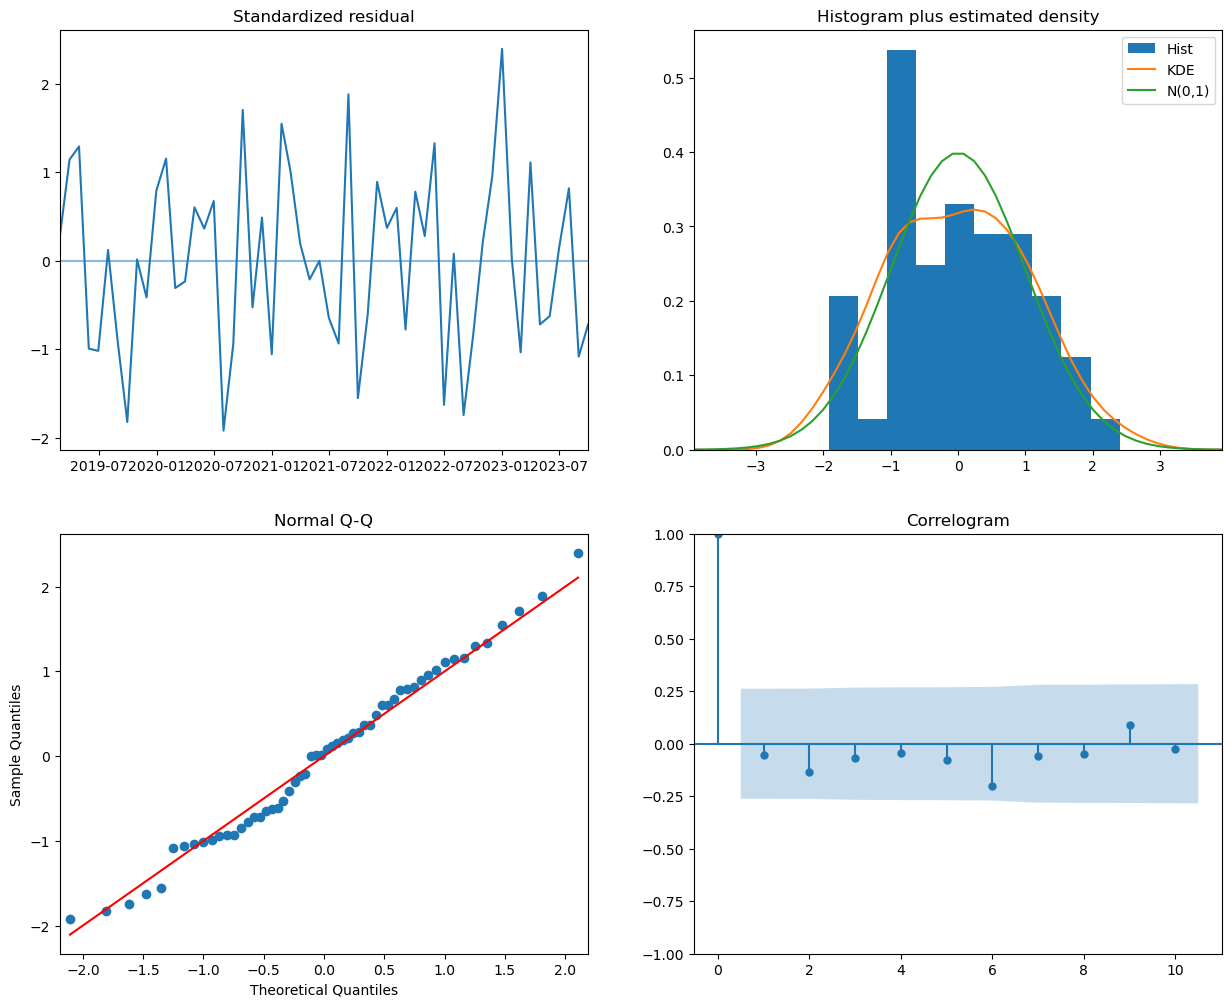

In [74]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [76]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_df['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)

Text(0.5, 1.0, 'Earbuds R1')

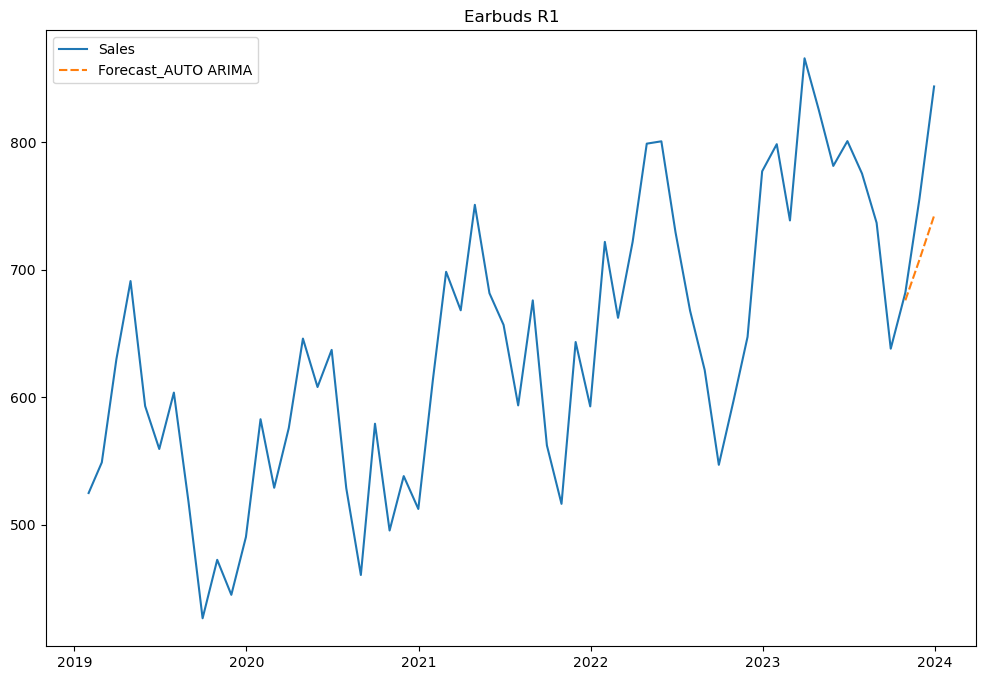

In [77]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_df[['Sales','Forecast_AUTO ARIMA']])
plt.title('Earbuds R1')

In [78]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 51.808240438615485
MAPE - AUTO ARIMA: 0.06417040876512953
MSE - AUTO ARIMA: 4208.857971576858
RMSE - AUTO ARIMA: 64.87571172308523
